In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import LogNorm

In [2]:
def load_obj_normals(path):
    ns = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            if line.startswith('vn '):
                parts = line.strip().split()
                if len(parts) < 4:
                    continue
                _, x, y, z = parts[:4]
                n = np.array([float(x), float(y), float(z)], dtype=np.float64)
                L = np.linalg.norm(n)
                if L > 0:
                    ns.append(n / L)
    if not ns:
        raise ValueError("No 'vn' normals found in the OBJ.")
    return np.vstack(ns)


def load_obj_geometry(path):
    """Load vertices and faces from OBJ file for area-weighted NDF computation."""
    vertices = []
    faces = []
    
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if line.startswith('v '):
                parts = line.split()
                if len(parts) >= 4:
                    x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
                    vertices.append([x, y, z])
            elif line.startswith('f '):
                parts = line.split()[1:]  # Skip 'f'
                if len(parts) >= 3:
                    # Parse face indices (handle v/vt/vn format)
                    face_indices = []
                    for part in parts[:3]:  # Take first 3 vertices for triangle
                        # Split by '/' and take first index (vertex)
                        idx_str = part.split('/')[0]
                        idx = int(idx_str) - 1  # OBJ uses 1-based indexing
                        face_indices.append(idx)
                    faces.append(face_indices)
    
    if not vertices:
        raise ValueError("No vertices found in OBJ file")
    if not faces:
        raise ValueError("No faces found in OBJ file")
    
    return np.array(vertices, dtype=np.float64), faces

In [3]:
def normals_to_ndf_xy(normals):
    # normals: Nx3 array, assumed normalized
    # z is the macroscopic normal direction
    x, y, z = normals[:, 0], normals[:, 1], normals[:, 2]
    theta = np.arccos(np.clip(z, -1, 1))  # theta: angle from z-axis
    phi = np.arctan2(y, x)                # phi: angle in x-y plane
    ndf_x = np.cos(phi) * np.sin(theta)
    ndf_y = np.sin(phi) * np.sin(theta)
    return np.stack([ndf_x, ndf_y], axis=1)


def area_weighted_ndf(vertices, faces):
    # Compute area-weighted normal distribution function (NDF) in xy
    ndf_samples = []
    area_weights = [] 
    for face in faces:
        v0, v1, v2 = vertices[face]
        # Compute face normal
        n = np.cross(v1 - v0, v2 - v0)
        area = np.linalg.norm(n) / 2
        if area == 0:
            continue
        n = n / np.linalg.norm(n)
        ndf_xy = normals_to_ndf_xy(n[np.newaxis, :])[0]
        ndf_samples.append(ndf_xy)
        area_weights.append(area)
    ndf_samples = np.array(ndf_samples)
    area_weights = np.array(area_weights)
    return ndf_samples, area_weights



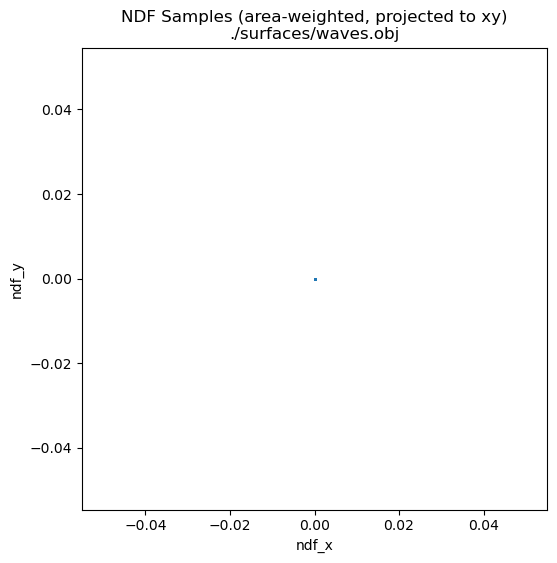

In [4]:
# Load geometry and compute area-weighted NDF samples
pathname = './surfaces/waves.obj'
vertices, faces = load_obj_geometry(pathname)  # Fixed: use pathname instead of undefined path
ndf_samples, area_weights = area_weighted_ndf(vertices, faces)


plt.figure(figsize=(6, 6))
plt.scatter(ndf_samples[:, 0], ndf_samples[:, 1], s=1, alpha=0.3)
plt.xlabel('ndf_x')
plt.ylabel('ndf_y')
plt.title(f'NDF Samples (area-weighted, projected to xy)\n{pathname}')
plt.axis('equal')
plt.show()

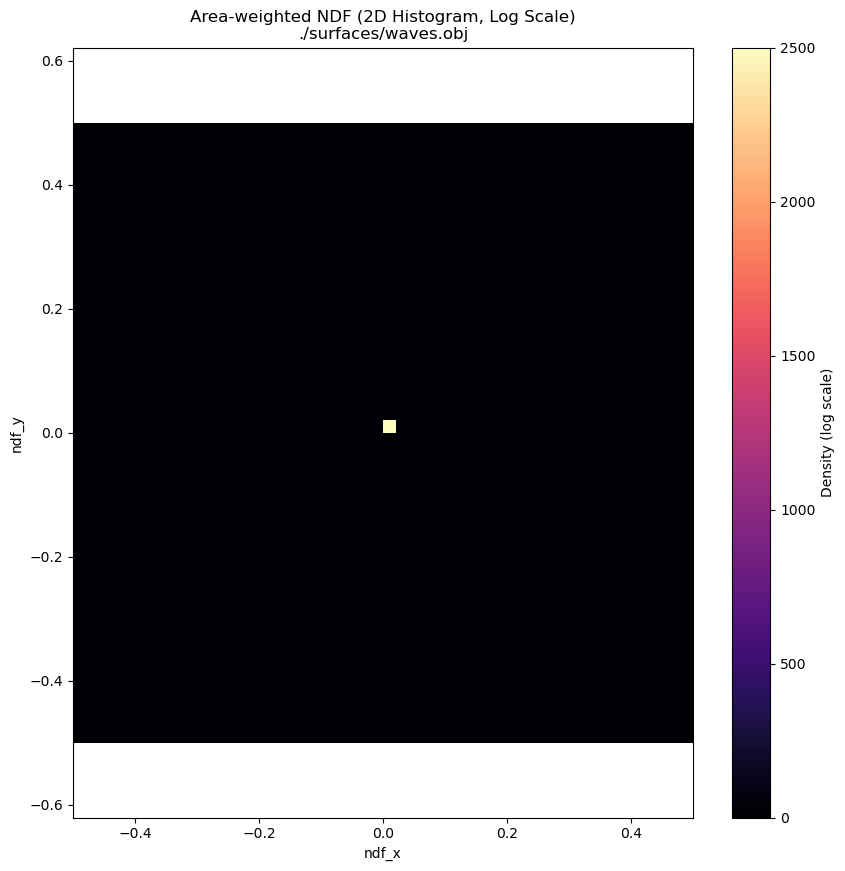

In [ ]:
# Plot a 2D histogram (area-weighted) with logarithmic color scale for better visualization
plt.figure(figsize=(10, 10))
hist2d, xedges, yedges, img = plt.hist2d(
    ndf_samples[:, 0], ndf_samples[:, 1],
    bins=50,
    weights=area_weights,
    density=True,
    cmap='magma',  
    norm=LogNorm(vmax=np.max(area_weights))
)
plt.xlabel('ndf_x')
plt.ylabel('ndf_y')
plt.colorbar(label='Density (log scale)')
plt.title(f'Area-weighted NDF (2D Histogram, Log Scale)\n{pathname}')
plt.axis('equal')
plt.show()


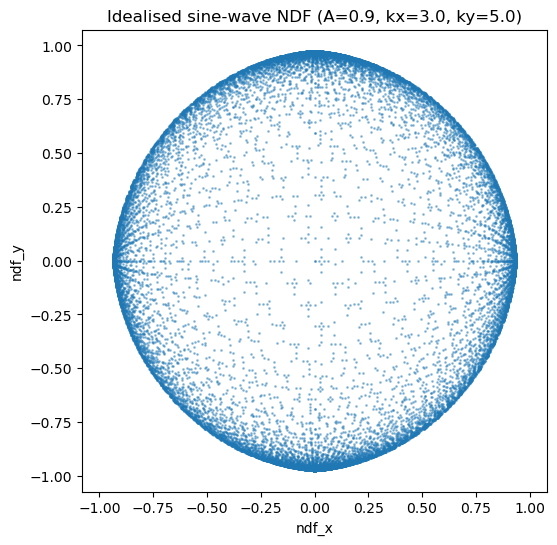

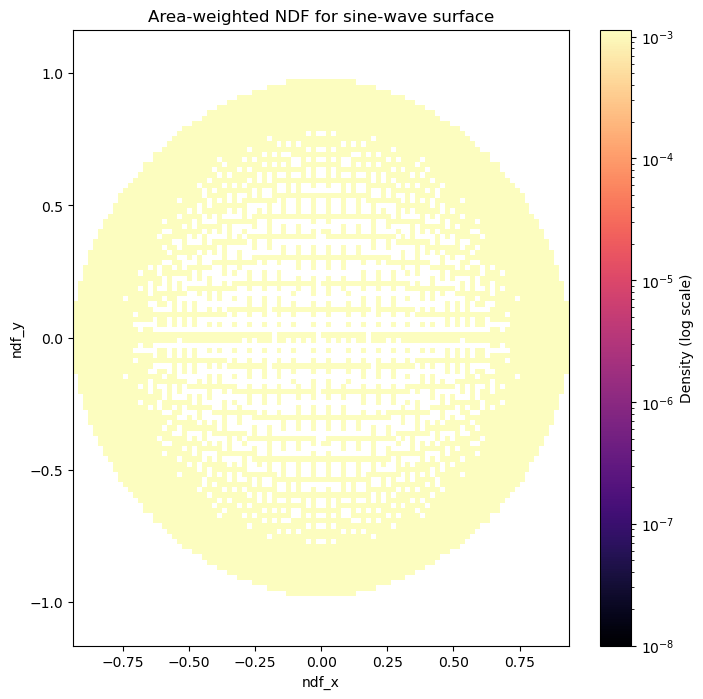

In [6]:
# Idealised NDF for a 2D sine-wave heightfield z = A * sin(kx*x) * sin(ky*y)
A = 0.9          # amplitude
kx = 3.0         # spatial frequency in x
ky = 5.0         # spatial frequency in y
nx, ny = 400, 400

# domain (one or more periods)
x = np.linspace(0, 2 * np.pi, nx)
y = np.linspace(0, 2 * np.pi, ny)
xx, yy = np.meshgrid(x, y)

# heightfield and partial derivatives
z = A * np.sin(kx * xx) * np.sin(ky * yy)
fz_x = A * kx * np.cos(kx * xx) * np.sin(ky * yy)
fz_y = A * ky * np.sin(kx * xx) * np.cos(ky * yy)

# normals: n = (-dz/dx, -dz/dy, 1) normalized
nx_field = -fz_x
ny_field = -fz_y
nz_field = np.ones_like(nx_field)
L = np.sqrt(nx_field**2 + ny_field**2 + nz_field**2)
normals_field = np.stack([nx_field / L, ny_field / L, nz_field / L], axis=-1)
normals_flat = normals_field.reshape(-1, 3)

# convert to ndf xy coordinates and compute area weights (local surface element)
ndf_sine = normals_to_ndf_xy(normals_flat)
dx = x[1] - x[0]
dy = y[1] - y[0]
area_element = np.sqrt(1.0 + fz_x**2 + fz_y**2) * dx * dy
area_weights_flat = area_element.ravel()

# Scatter plot (subsample for speed)
sub = np.linspace(0, ndf_sine.shape[0]-1, 20000, dtype=int)
plt.figure(figsize=(6, 6))
plt.scatter(ndf_sine[sub, 0], ndf_sine[sub, 1], s=1, alpha=0.4)
plt.xlabel('ndf_x'); plt.ylabel('ndf_y')
plt.title(f'Idealised sine-wave NDF (A={A}, kx={kx}, ky={ky})')
plt.axis('equal')
plt.show()

# 2D histogram (area-weighted) with log color scale
plt.figure(figsize=(8, 8))
hist2d, xedges, yedges, img = plt.hist2d(
    ndf_sine[:, 0], ndf_sine[:, 1],
    bins=100,
    weights=area_weights_flat,
    density=True,
    cmap='magma',
    norm=LogNorm(vmin=1e-8, vmax=area_weights_flat.max())
)
plt.xlabel('ndf_x'); plt.ylabel('ndf_y')
plt.colorbar(label='Density (log scale)')
plt.title('Area-weighted NDF for sine-wave surface')
plt.axis('equal')
plt.show()